In [1]:
#Import all libraries.
import pandas as pd
import math
from astropy.io import fits
import os
from astropy.wcs import WCS
import numpy as np
import keyring
from astroquery.astrometry_net import AstrometryNet
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import warnings
from IPython.display import clear_output
import os.path

warnings.filterwarnings('ignore')

In [2]:
#PARAMETERS - User input.
#Program assumes Mira photometry CSV and that image is 4096x4096.

target = 'K01'

rawMira = './KeplerTest2/testdata4zach_v02.csv' #'./VariableStarExtras/M3-AutoPhotometry.csv'
directory = 'C:/Users/ronald.sumners/Desktop/KeplerTest2'
rawFit = 'C:/Users/ronald.sumners/Desktop/KeplerTest2/6661513_32683501_d_f1.fits'#directory + '/Reg/6661513_32683501_d_f1.fits'
croppedFitOutput = "C:/Users/ronald.sumners/Desktop/KeplerTest2/CroppedFit/K01_WCS_Crop_"
parametersOutput = 'KeplerTest2_Parameters.csv'

AstrometryNet.key = 'cibwfruamvhkzmdd'

nonVariableThreshold = 0.6
variabilityThreshold = 0.2
uncertainThreshold = 4 #The resolution of the BN is 3.8"/px
unclassifiedThreshold = 6
numStars = 22
numImages = 64

In [3]:
#Import the raw star photometry data from Mira CSV
starData = pd.read_csv(rawMira)
starData.columns = starData.columns.str.replace(' ', '')
starData = starData.set_index('#')

In [4]:
#Create star parameters dataframe. Get locations and names of stars. 
#Also get magnitude and error of each star. Store them in dataframes.
x = []
y = []
starName = starData['Name'][:numStars]

magnitude_dict = {}
errors_dict = {}
 
for i in range(numStars):
    #name1 = target + '-' + str(i)
    #starName.append(name1)
    clear_output(wait=True)
    print(f'PROGRESS: {(i/(numStars-1))*100:.1f}%')
    
    name1 = starName.iloc[i]
    
    x.append(starData['X'][starData['Name'] == name1].reset_index(drop=True)[0])
    y.append(starData['Y'][starData['Name'] == name1].reset_index(drop=True)[0])
    
    magnitude_dict[name1] = starData['Mag'][starData['Name'] == name1].reset_index(drop=True)
    errors_dict[name1] = starData['Error(T)'][starData['Name'] == name1].reset_index(drop=True)


starParams = pd.DataFrame(data={'x': x, 'y': y}, index=starName)

starMagnitudes = pd.DataFrame(magnitude_dict)
starErrors = pd.DataFrame(errors_dict)

PROGRESS: 100.0%


In [5]:
#Split the 4096x4096 photometry image into 16 different sections.

if not os.path.isfile(parametersOutput):
    data, header = fits.getdata(rawFit, header = True)

    for i in range(4):
        for j in range(4):
            hdu = fits.PrimaryHDU(data[1024*i:1024*(i+1), 1024*j:1024*(j+1)])
            hdu.writeto(croppedFitOutput + f"{4*i + j}.fits", overwrite = True)

    x = starParams['x']
    y = starParams['y']

    quad = []
    for i in range(numStars):
        quadrant_x = x[i]//1024
        quadrant_y = y[i]//1024
        quad.append(quadrant_x + 4*quadrant_y)

    starParams['Quadrant'] = quad
else:
    starParams = pd.read_csv(parametersOutput)
    starParams = starParams.set_index('Name')
    print('Already completed. Skip.')

Already completed. Skip.


In [6]:
#Run those split images through Astrometry to get WCS headers. 
#Use those headers to find the real sky coordinates of each star.

if not os.path.isfile(parametersOutput):

    w = []
    for i in range(16):
        print(f'\nQuadrant {i}')

        try_again = True
        submission_id = None

        while try_again:
            try:
                if not submission_id:
                    # Solves the image from the file path
                    wcs_header = AstrometryNet.solve_from_image(croppedFitOutput + f'{i}.fits', force_image_upload=True,
                                                      submission_id=submission_id, detect_threshold=3, solve_timeout=1000)
                else:
                    #  Time is in seconds.
                    wcs_header = AstrometryNet.monitor_submission(
                        submission_id, solve_timeout=1000)
            except TimeoutError as e:
                #  Timeout error, never triggers. Basically useless code since it never triggers during timeout error
                submission_id = e.args[1]
                print('\nThere was a timeout error. ( Process took to long ).')
                print('Astometry.net could also be down at the moment.')
            else:
                #! got a result, so terminate
                try_again = False

        if wcs_header:
            w.append(wcs_header)


    Ra = []
    Dec = []
    for i in range(1, numStars + 1):
        quadrant = starParams['Quadrant'][i-1]
        wc = WCS(w[int(quadrant)])
        sky = wc.pixel_to_world_values(starParams.iloc[i-1, 0]-1024*(starParams.iloc[i-1, 0]//1024), starParams.iloc[i-1, 1]-1024*(starParams.iloc[i-1, 1]//1024))

        Ra.append(sky[0].item())
        Dec.append(sky[1].item())

    newra = [x + 0.00185728 for x in Ra]
    newdec = [y + 0.000917002 for y in Dec]

    starParams['RA'] = newra
    starParams['Dec'] = newdec
else:
    print('Already completed. Skip.')

Already completed. Skip.


In [7]:
#Gets the magnitudes and magnitude errors of each star over time from the raw Mira CSV. Useful for differential photometry.
#magnitude_dict = {}
#errors_dict = {}
#starName = starData['Name'][:numStars]
 
#for i in range(numStars):
#    name = starName.iloc[i]
#    magnitude_dict[name] = starData['Mag'][starData['Name'] == name].reset_index(drop=True)
#    errors_dict[name] = starData['Error(T)'][starData['Name'] == name].reset_index(drop=True)

#starMagnitudes = pd.DataFrame(magnitude_dict)
#starErrors = pd.DataFrame(errors_dict)

In [8]:
#Look up what type of object each star is with Simbad (based on real coordinates found earlier).
#If object is within uncertainThreshold arcseconds of another, list type as uncertain. 
#If more than unclassifiedThreshold arcseconds, it is not catalogued.

if not os.path.isfile(parametersOutput):
    starTypeList = []

    custom_simbad = Simbad()
    custom_simbad.add_votable_fields('otype')
    custom_simbad.add_votable_fields('distance_result')
    types = []
    for i in range(numStars):
        clear_output(wait=True)
        print(f'PROGRESS: {(i/(numStars-1))*100:.1f}%')
        coord1 = starParams['RA'].iloc[i]
        coord2 = starParams['Dec'].iloc[i]

        c = SkyCoord(coord1, coord2, frame='icrs', unit='deg')

        transformed_c = c.to_string('hmsdms')

        r = 2 * u.arcminute

        result_table = custom_simbad.query_region(c, radius=r)

        try:
            starType = 'STAR'#result_table['OTYPE'][0]

            if starType not in types:
                types.append(starType)

            starTypeList.append(starType)

            if len(result_table['DISTANCE_RESULT']) > 1:
                if (result_table['OTYPE'][0] == 'Planet' or  result_table['OTYPE'][1] == 'Planet'):
                    starTypeList[-1] = 'EXOPLANET'
                elif (result_table['DISTANCE_RESULT'][1]-result_table['DISTANCE_RESULT'][0]) < uncertainThreshold:
                    starTypeList[-1] = 'UNCERTAIN'
                elif (result_table['DISTANCE_RESULT'][0]) > unclassifiedThreshold:
                    starTypeList[-1] = 'UNCLASSIFIED'
            else:
                if result_table['DISTANCE_RESULT'][0] > unclassifiedThreshold:
                    starTypeList[-1] = 'UNCLASSIFIED'
        except TypeError:
            starTypeList.append('UNCLASSIFIED')
            continue


    starParams['Type'] = starTypeList
else:
    print('Already completed. Skip.')

Already completed. Skip.


In [9]:
#Confirm which stars are already classified variable stars. Remove them from the analysis.
#Make special note of which stars uncertain or unclassified.
#Uncertain stars MAY BE variables. Manual lookup needed.
#For the rest of the stars, use those who have variations less than x for differential photometry.

variables = starParams.index[
    (starParams['Type'] == 'RRLyrae') | (starParams['Type'] == 'EclBin') | 
    (starParams['Type'] == 'RotV*') | (starParams['Type'] == 'LongPeriodV*') | 
    (starParams['Type'] == 'LongPeriodV*_Candidate') | (starParams['Type'] == 'gammaDorV*')
    | (starParams['Type'] == 'delSctV*') | (starParams['Type'] == 'Variable*') | (starParams['Type'] == 'EclBin_Candidate')].tolist()
uncertain = starParams.index[(starParams['Type'] == 'UNCERTAIN') | (starParams['Type'] == 'UNCLASSIFIED')].tolist()
planets = starParams.index[starParams['Type'] == 'EXOPLANET'].tolist()


#nonVariables = []

#for i in range(numStars):
#    name = starName.iloc[i]
#    if starMagnitudes.iloc[:, i].max()-starMagnitudes.iloc[:, i].min() < nonVariableThreshold and name not in variables and name not in planets:
#        nonVariables.append(name)
    
print(f'CONFIRMED VARAIBLE STARS - {len(variables)}: \n{variables}\n')
print(f'POSSIBLE EXOPLANET SYSTEMS - {len(planets)}: \n{planets}\n')
print(f'UNCERTAIN OR UNCLASSIFIED STARS - {len(uncertain)}: \n{uncertain}\n')
#print(f'NON VARIABLE COMPARISON STARS - {len(nonVariables)}: \n{nonVariables}\n')

CONFIRMED VARAIBLE STARS - 0: 
[]

POSSIBLE EXOPLANET SYSTEMS - 0: 
[]

UNCERTAIN OR UNCLASSIFIED STARS - 4: 
['K01-1106', 'K01-1162', 'K01-1169', 'K01-1209']



In [10]:
#Function to find the nearest neighbouring star. Copied from Github.

class KDTree(object):
    
    """
    A super short KD-Tree for points...
    so concise that you can copypasta into your homework 
    without arousing suspicion.

    This implementation only supports Euclidean distance. 

    The points can be any array-like type, e.g: 
        lists, tuples, numpy arrays.

    Usage:
    1. Make the KD-Tree:
        `kd_tree = KDTree(points, dim)`
    2. You can then use `get_knn` for k nearest neighbors or 
       `get_nearest` for the nearest neighbor

    points are be a list of points: [[0, 1, 2], [12.3, 4.5, 2.3], ...]
    """
    def __init__(self, points, dim, dist_sq_func=None):
        """Makes the KD-Tree for fast lookup.

        Parameters
        ----------
        points : list<point>
            A list of points.
        dim : int 
            The dimension of the points. 
        dist_sq_func : function(point, point), optional
            A function that returns the squared Euclidean distance
            between the two points. 
            If omitted, it uses the default implementation.
        """

        if dist_sq_func is None:
            dist_sq_func = lambda a, b: sum((x - b[i]) ** 2 
                for i, x in enumerate(a))
                
        def make(points, i=0):
            if len(points) > 1:
                points.sort(key=lambda x: x[i])
                i = (i + 1) % dim
                m = len(points) >> 1
                return [make(points[:m], i), make(points[m + 1:], i), 
                    points[m]]
            if len(points) == 1:
                return [None, None, points[0]]
        
        def add_point(node, point, i=0):
            if node is not None:
                dx = node[2][i] - point[i]
                for j, c in ((0, dx >= 0), (1, dx < 0)):
                    if c and node[j] is None:
                        node[j] = [None, None, point]
                    elif c:
                        add_point(node[j], point, (i + 1) % dim)

        import heapq
        def get_knn(node, point, k, return_dist_sq, heap, i=0, tiebreaker=1):
            if node is not None:
                dist_sq = dist_sq_func(point, node[2])
                dx = node[2][i] - point[i]
                if len(heap) < k:
                    heapq.heappush(heap, (-dist_sq, tiebreaker, node[2]))
                elif dist_sq < -heap[0][0]:
                    heapq.heappushpop(heap, (-dist_sq, tiebreaker, node[2]))
                i = (i + 1) % dim
                # Goes into the left branch, then the right branch if needed
                for b in (dx < 0, dx >= 0)[:1 + (dx * dx < -heap[0][0])]:
                    get_knn(node[b], point, k, return_dist_sq, 
                        heap, i, (tiebreaker << 1) | b)
            if tiebreaker == 1:
                return [(-h[0], h[2]) if return_dist_sq else h[2] 
                    for h in sorted(heap)][::-1]

        def walk(node):
            if node is not None:
                for j in 0, 1:
                    for x in walk(node[j]):
                        yield x
                yield node[2]

        self._add_point = add_point
        self._get_knn = get_knn 
        self._root = make(points)
        self._walk = walk

    def __iter__(self):
        return self._walk(self._root)
        
    def add_point(self, point):
        """Adds a point to the kd-tree.
        
        Parameters
        ----------
        point : array-like
            The point.
        """
        if self._root is None:
            self._root = [None, None, point]
        else:
            self._add_point(self._root, point)

    def get_knn(self, point, k, return_dist_sq=True):
        """Returns k nearest neighbors.

        Parameters
        ----------
        point : array-like
            The point.
        k: int 
            The number of nearest neighbors.
        return_dist_sq : boolean
            Whether to return the squared Euclidean distances.

        Returns
        -------
        list<array-like>
            The nearest neighbors. 
            If `return_dist_sq` is true, the return will be:
                [(dist_sq, point), ...]
            else:
                [point, ...]
        """
        return self._get_knn(self._root, point, k, return_dist_sq, [])

    def get_nearest(self, point, return_dist_sq=True):
        """Returns the nearest neighbor.

        Parameters
        ----------
        point : array-like
            The point.
        return_dist_sq : boolean
            Whether to return the squared Euclidean distance.

        Returns
        -------
        array-like
            The nearest neighbor. 
            If the tree is empty, returns `None`.
            If `return_dist_sq` is true, the return will be:
                (dist_sq, point)
            else:
                point
        """
        l = self._get_knn(self._root, point, 1, return_dist_sq, [])
        return l[0] if len(l) else None


In [11]:
#Calculate which stars are to be used as comparison stars.

positions = list(zip(starParams['x'], starParams['y']))
comparisonStars = []
x = np.linspace(0, 48, 48)

for i in range(numStars):
    name = starName.iloc[i]
    allComparisonDifferentials = pd.DataFrame({})
    distance = []
    flagCount = 0
    
    tree = KDTree(positions, 2)
    knn = tree.get_knn([starParams['x'].loc[name], starParams['y'].loc[name]], 11, False)
    
    
    starParamsSearch = starParams.reset_index()
    starParamsSearch = starParamsSearch.astype(str)
    
    clear_output(wait=True)
    print(f'PROGRESS: {(i/(numStars-1))*100:.1f}%')
    for coords in knn:
        x = str(coords[0])
        y = str(coords[1])
        
        comparisonName = starParamsSearch['Name'].loc[(starParamsSearch['x'] == x) & (starParamsSearch['y'] == y)].iloc[0]
        if comparisonName == name:
            continue
        
        
        normalized1 = (starMagnitudes[name] - starMagnitudes[name].min())/(starMagnitudes[name].max() - starMagnitudes[name].min())
        normalized2 = (starMagnitudes[comparisonName] - starMagnitudes[comparisonName].min())/(starMagnitudes[comparisonName].max() - starMagnitudes[comparisonName].min())
        
        normalized1_smooth = savgol_filter(normalized1, 20, 2)
        normalized2_smooth = savgol_filter(normalized2, 20, 2)
        
        distance = 1/len(normalized1_smooth) * np.sum(np.square(normalized1_smooth - normalized2_smooth))
        #print(normalized1)
        #print(distance)
        #plt.plot(normalized1_smooth)
        #plt.plot(normalized2_smooth)
        #plt.show()
        #if distance < 0.01:
        #    plt.plot(normalized1)
        #    plt.plot(normalized2)
        #    print(distance)
        #    plt.show()
        print(distance)
        if distance > 0.005:
            flagCount += 1
    
    if flagCount < 5 and name not in variables:
        comparisonStars.append(name)
print(len(comparisonStars))

PROGRESS: 100.0%
0.0016326812861841564
0.0015314103059808812
0.015587405825827516
0.0028983266322369335
0.0007239824823750756
0.004372691355845386
0.0015519550895874922
0.0029349534002958665
0.0296758973128186
0.0003721335672052193
20


In [12]:
#Calculates the difference in magnitude between star and the non variables found earlier.
#Output star parameters and magnitude differential to CSV.

numComparison = 10

differential_magnitude_dict = {}
comparisonStars_dict = {}
finalError_dict = {}

positions = list(zip(starParams['x'].loc[comparisonStars], starParams['y'].loc[comparisonStars]))

for j in range(numStars):
    totalDifferentials = pd.DataFrame({})
    totalErrors = pd.DataFrame({})
    tree = KDTree(positions, 2)
    
    name = starName.iloc[j]
    
    knn = tree.get_knn([starParams['x'].loc[name], starParams['y'].loc[name]], numComparison, False)
    
    differentialComparisonStars = []
    starParamsSearch = starParams.reset_index()
    starParamsSearch = starParamsSearch.astype(str)
    
    clear_output(wait=True)
    print(f'PROGRESS: {(j/(numStars-1))*100:.1f}%')
    
    for coords in knn:
        x = str(coords[0])
        y = str(coords[1])
        
        comparisonName = starParamsSearch['Name'].loc[(starParamsSearch['x'] == x) & (starParamsSearch['y'] == y)].iloc[0]
        differentialComparisonStars.append(comparisonName)
    
    comparisonStars_dict[name + ' Comparison'] = differentialComparisonStars
    for k in range(len(differentialComparisonStars)):
        name2 = differentialComparisonStars[k]
        
        differential = starMagnitudes[name] - starMagnitudes[name2]

        differentialError = np.sqrt(np.square(starErrors[name]) + np.square(starErrors[name2]))
        totalErrors = pd.concat([totalErrors, differentialError.rename(str(name2))], axis=1)
        
        totalDifferentials = pd.concat([totalDifferentials, differential.rename(str(k+1))], axis=1)
    
    differential_magnitude_dict[name + ' Differential'] = totalDifferentials.median(axis=1)

    finalError_dict[name + ' Error'] = np.sqrt(np.square(totalErrors).sum(axis=1))/numComparison


differentialMagnitudes = pd.DataFrame(differential_magnitude_dict)
differentials = pd.DataFrame(data = differentialMagnitudes)
differentials.to_csv(f'{target}_MagnitudeDifferentials.csv', index=False)

comparisonStarsDF = pd.DataFrame(comparisonStars_dict)
comparisonStarsDF.to_csv(f'{target}_ComparisonStars.csv', index=False)

finalErrorDF = pd.DataFrame(finalError_dict)
finalErrorDF.to_csv(f'{target}_DifferentialErrors.csv', index=False)

starParams.to_csv(parametersOutput, index=True)

PROGRESS: 100.0%


In [13]:
print(starMagnitudes)

    K01-1004  K01-1064  K01-1100  K01-1106  K01-1125   K01-1144  K01-1162  \
0  -8.029183 -9.318784 -8.548281 -9.041471 -8.984825 -10.888672 -8.275120   
1  -7.984628 -9.218490 -8.487617 -9.032713 -9.068423 -10.804602 -8.288991   
2  -8.019618 -9.340577 -8.365329 -8.958437 -8.999854 -10.878531 -8.213658   
3  -8.122446 -9.245979 -8.411505 -8.855859 -8.859927 -10.834615 -8.287752   
4  -8.118583 -9.156663 -8.484097 -9.010219 -8.994543 -10.778617 -8.179610   
..       ...       ...       ...       ...       ...        ...       ...   
59 -7.158346 -8.353680 -7.601689 -8.072738 -8.023311 -10.061142 -7.472102   
60 -7.179849 -8.324123 -7.502845 -8.112662 -8.140899  -9.931410 -7.442393   
61 -7.144251 -8.417621 -7.606818 -8.104953 -8.016039 -10.033130 -7.430414   
62 -7.206714 -8.288567 -7.546166 -8.070735 -7.999085 -10.019765 -7.399359   
63 -7.198118 -8.366355 -7.470474 -8.020522 -8.139364  -9.848609 -7.344118   

    K01-1169   K01-1191   K01-1206  ...   K01-1240  K01-1241   K01-1340  \


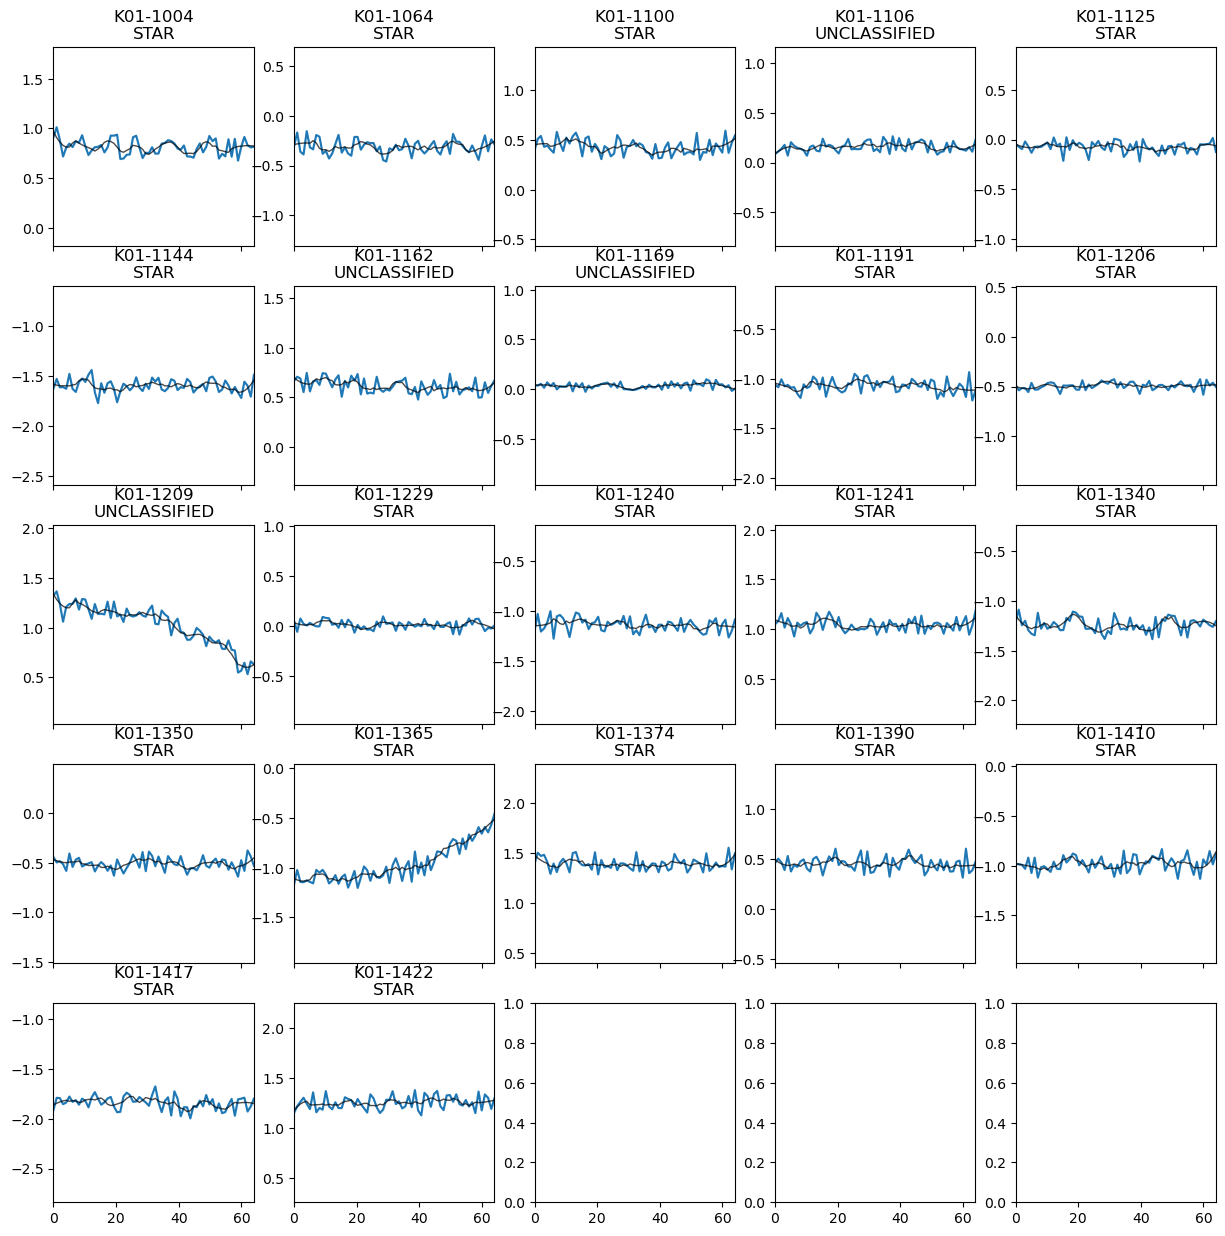

In [14]:
#Plot differential photometry of all stars.

rows = 5
start = 0

offset = 0
fig, axs = plt.subplots(rows, 5, sharex = True, sharey = False, figsize = (15, 3*rows))

x = np.linspace(0, len(differentialMagnitudes), len(differentialMagnitudes))
count = 0

errorData = pd.read_csv(f'{target}_DifferentialErrors.csv')

for star in starName[start:start+5*rows]:
    j = count % 5
    i = count //5

    try:
        axs[i, j].plot(x, differentialMagnitudes[f'{star} Differential'])
        axs[i, j].fill_between(x, 
                   differentialMagnitudes[f'{star} Differential'] - errorData[f'{star} Error'],
                   differentialMagnitudes[f'{star} Differential'] + errorData[f'{star} Error'],
                   alpha=0.2, color='#26a8ff')
        smoothed = savgol_filter(differentialMagnitudes[f'{star} Differential'].to_numpy(), 10, 2)
        axs[i, j].plot(x, smoothed, 'black', alpha=0.7, linewidth=1)
        axs[i, j].set_title(f'{star}\n{starParams["Type"].loc[star]}')
        axs[i, j].set_ylim(differentialMagnitudes[f'{star} Differential'].mean()-1, differentialMagnitudes[f'{star} Differential'].mean()+1)
        axs[i, j].set_xlim(0, numImages)

    except:
        continue
    count += 1

plt.show()

In [15]:
flagVariable = []

for star in starName:
    try:
        mags_smooth = savgol_filter(differentialMagnitudes[f'{star} Differential'].to_numpy(), 10, 2)
        if mags_smooth.max() - mags_smooth.min() > variabilityThreshold and f'{star}' not in variables:
            flagVariable.append(f'{star}')
    except:
        continue
print(f'{len(flagVariable)} stars with variations above {variabilityThreshold} magnitudes.')

3 stars with variations above 0.2 magnitudes.


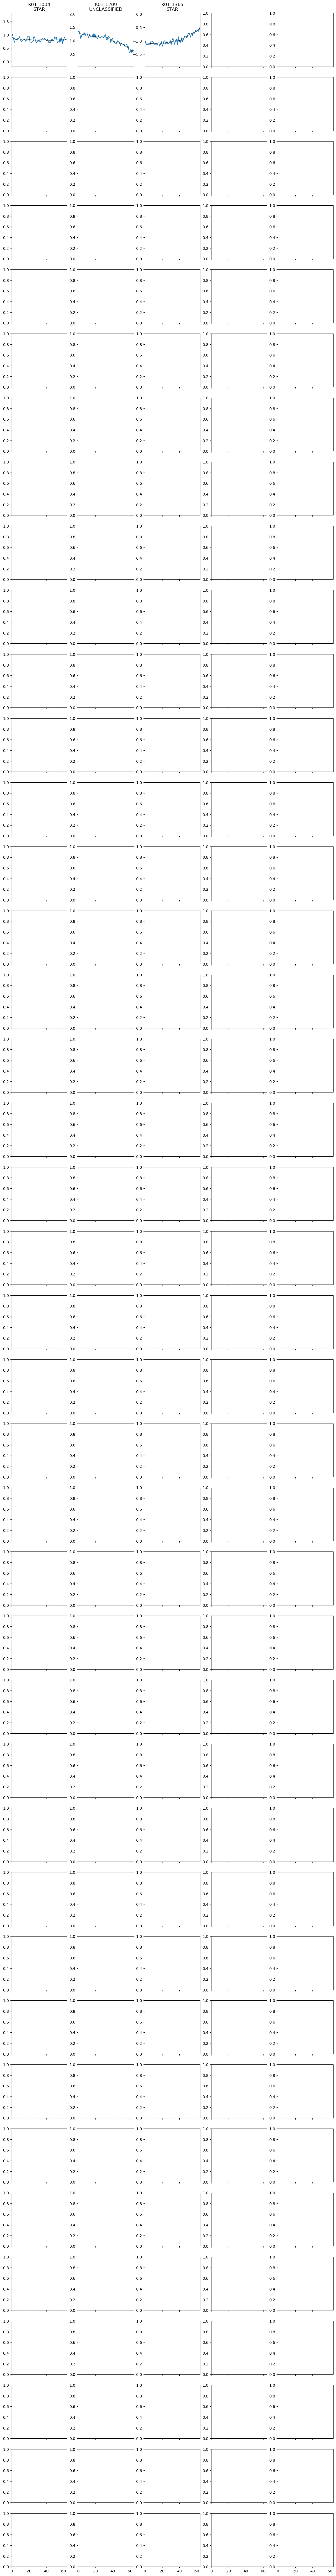

In [16]:
#Plot differential photometry of possible new variables.
rows = 40

fig, axs = plt.subplots(rows, 5, sharex = True, sharey = False, figsize = (15, 3*rows))

count = 0

x = np.linspace(0, len(differentialMagnitudes), len(differentialMagnitudes))
for star in flagVariable[:]:
    j = count % 5
    i = count //5
    
    if i >= rows:
        break

    axs[i, j].plot(x, differentialMagnitudes[f'{star} Differential'])
    axs[i, j].fill_between(x, 
               differentialMagnitudes[f'{star} Differential'] - errorData[f'{star} Error'],
               differentialMagnitudes[f'{star} Differential'] + errorData[f'{star} Error'],
               alpha=0.2, color='#26a8ff')
    smoothed = savgol_filter(differentialMagnitudes[f'{star} Differential'].to_numpy(), 20, 2)
    axs[i, j].plot(x, smoothed, 'black', alpha=0.7, linewidth=1)
    axs[i, j].set_title(f'{star}\n{starParams["Type"].loc[star]}')
    axs[i, j].set_ylim(differentialMagnitudes[f'{star} Differential'].mean()-1, differentialMagnitudes[f'{star} Differential'].mean()+1)
    axs[i, j].set_xlim(0, numImages)
    count += 1
    
plt.show()

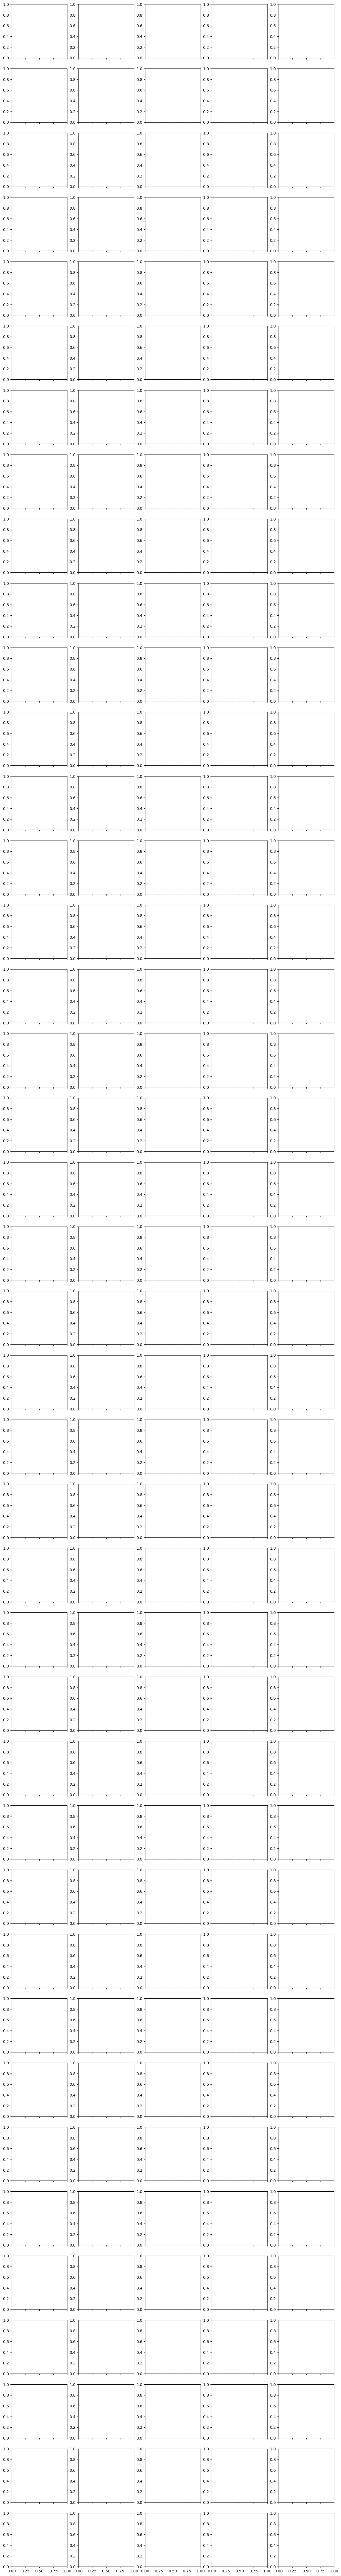

In [17]:
#Plot differential photometry of confirmed variables.
rows = 40

fig, axs = plt.subplots(rows, 5, sharex = True, sharey = False, figsize = (15, 3*rows))

count = 0

x = np.linspace(0, len(differentialMagnitudes), len(differentialMagnitudes))
for star in variables[:]:
    j = count % 5
    i = count //5
    
    if i >= rows:
        break

    axs[i, j].plot(x, differentialMagnitudes[f'{star} Differential'])
    axs[i, j].fill_between(x, 
               differentialMagnitudes[f'{star} Differential'] - errorData[f'{star} Error'],
               differentialMagnitudes[f'{star} Differential'] + errorData[f'{star} Error'],
               alpha=0.2, color='#26a8ff')
    smoothed = savgol_filter(differentialMagnitudes[f'{star} Differential'].to_numpy(), 20, 2)
    axs[i, j].plot(x, smoothed, 'black', alpha=0.7, linewidth=1)
    axs[i, j].set_title(f'{star}\n{starParams["Type"].loc[star]}')
    axs[i, j].set_ylim(differentialMagnitudes[f'{star} Differential'].mean()-1, differentialMagnitudes[f'{star} Differential'].mean()+1)
    axs[i, j].set_xlim(0, numImages)
    count += 1
    
plt.show()

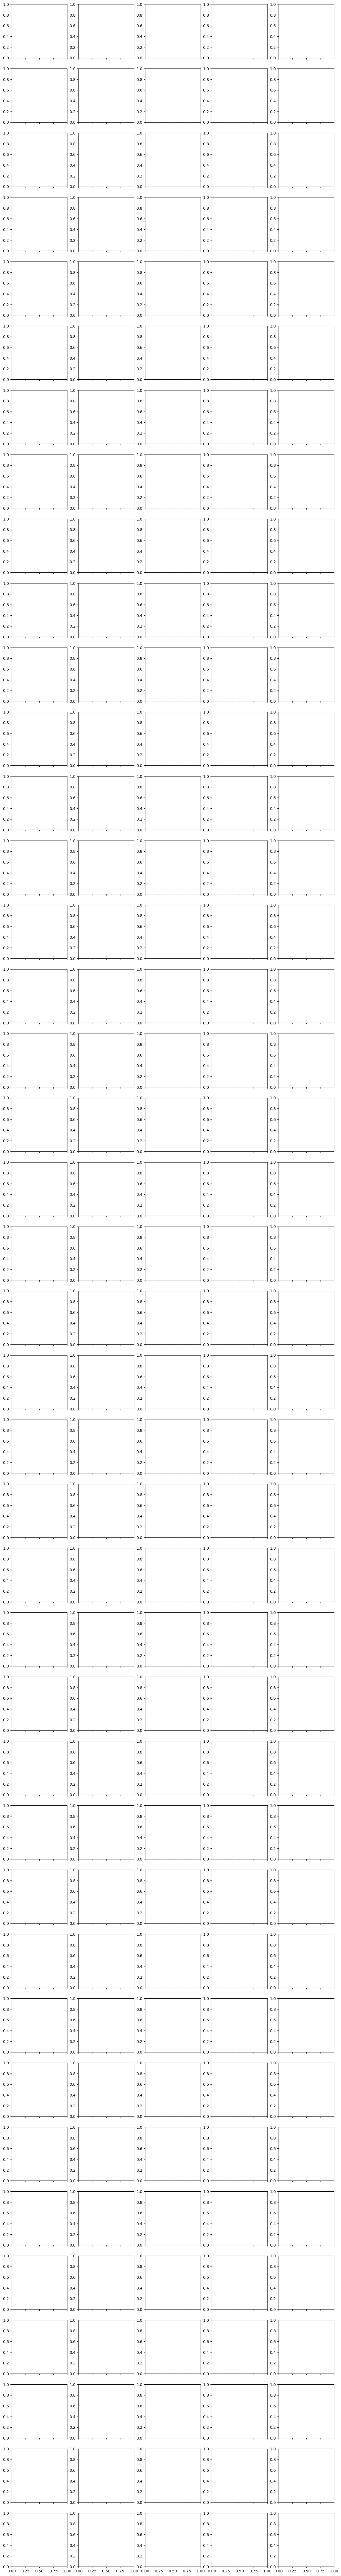

In [18]:
#Plot differential photometry of confirmed stars with exoplanets.
rows = 40

fig, axs = plt.subplots(rows, 5, sharex = True, sharey = False, figsize = (15, 3*rows))

count = 0

x = np.linspace(0, len(differentialMagnitudes), len(differentialMagnitudes))
for star in planets[:]:
    j = count % 5
    i = count //5
    
    if i >= rows:
        break

    axs[i, j].plot(x, differentialMagnitudes[f'{star} Differential'])
    axs[i, j].fill_between(x, 
               differentialMagnitudes[f'{star} Differential'] - errorData[f'{star} Error'],
               differentialMagnitudes[f'{star} Differential'] + errorData[f'{star} Error'],
               alpha=0.2, color='#26a8ff')
    smoothed = savgol_filter(differentialMagnitudes[f'{star} Differential'].to_numpy(), 20, 2)
    axs[i, j].plot(x, smoothed, 'black', alpha=0.7, linewidth=1)
    axs[i, j].set_title(f'{star}\n{starParams["Type"].loc[star]}')
    axs[i, j].set_ylim(differentialMagnitudes[f'{star} Differential'].mean()-1, differentialMagnitudes[f'{star} Differential'].mean()+1)
    axs[i, j].set_xlim(0, numImages)
    count += 1
    
plt.show()

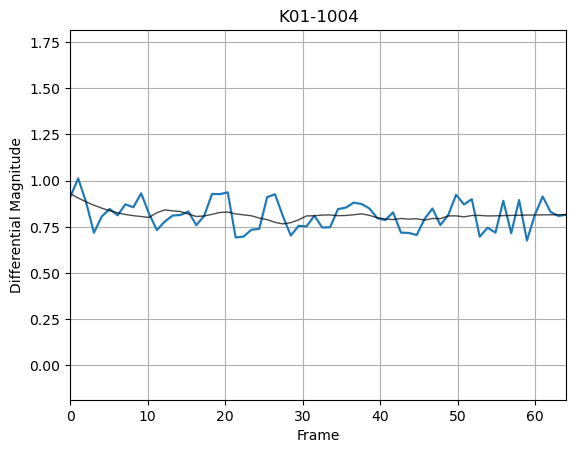

0    K01-1004
1    K01-1064
2    K01-1125
3    K01-1106
4    K01-1169
5    K01-1100
6    K01-1162
7    K01-1241
8    K01-1144
9    K01-1206
Name: K01-1004 Comparison, dtype: object


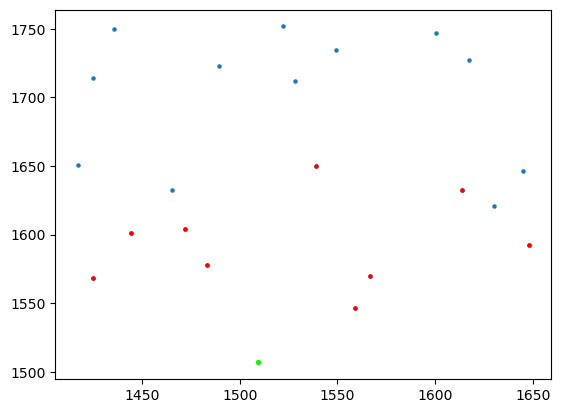

In [19]:
#Plot differential photometry of individual star for further investigation.

star = 1004
x = np.linspace(0, len(differentialMagnitudes), len(differentialMagnitudes))

figData = plt.gcf()
figData.set_size_inches(6.4, 4.8)

plt.plot(x, differentialMagnitudes[f'{target}-{star} Differential'].tolist())
plt.fill_between(x, 
               differentialMagnitudes[f'{target}-{star} Differential'].tolist() - errorData[f'{target}-{star} Error'],
              differentialMagnitudes[f'{target}-{star} Differential'].tolist() + errorData[f'{target}-{star} Error'],
               alpha=0.2, color='#26a8ff')

try:
    smoothed = savgol_filter(differentialMagnitudes[f'{target}-{star} Differential'].tolist(), 20, 2)
    plt.plot(x, smoothed, 'black', alpha=0.7, linewidth=1)
except:
    pass

#plt.axvline(x=105, color='black')
#plt.text(106.5, differentialMagnitudes.iloc[:, star-1].mean() - 0.95, '10 DAY SKIP', rotation=90)
plt.grid()
plt.title(f'{target}-{star}')
plt.ylim(differentialMagnitudes[f'{target}-{star} Differential'].to_numpy().mean()-1, differentialMagnitudes[f'{target}-{star} Differential'].to_numpy().mean()+1)
plt.xlim(0, numImages)
plt.xlabel('Frame')
plt.ylabel('Differential Magnitude')
plt.show()

figData = plt.gcf()
figData.set_size_inches(6.4, 4.8)

selection = star

comparisonData = pd.read_csv(f'{target}_ComparisonStars.csv')

selected = comparisonData[f'{target}-{selection} Comparison']
print(selected)                
plt.scatter(starParams['x'], starParams['y'], s = 5)
for comparison in selected:
    plt.scatter(starParams['x'].loc[comparison], starParams['y'].loc[comparison], color='r', s = 5)
plt.scatter(starParams['x'].loc[f'{target}-{selection}'], starParams['y'].loc[f'{target}-{selection}'], color='#09ff00', s=8)

plt.show()

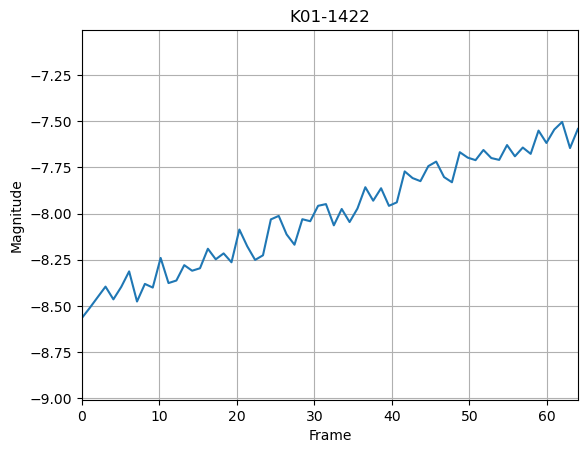

In [20]:
star = 1422
x = np.linspace(0, len(differentialMagnitudes), len(differentialMagnitudes))

figData = plt.gcf()
figData.set_size_inches(6.4, 4.8)

plt.plot(x, starMagnitudes[f'{target}-{star}'].tolist())

plt.grid()
plt.title(f'{target}-{star}')
plt.ylim(starMagnitudes[f'{target}-{star}'].to_numpy().mean()-1, starMagnitudes[f'{target}-{star}'].to_numpy().mean()+1)
plt.xlim(0, numImages)
plt.xlabel('Frame')
plt.ylabel('Magnitude')
plt.show()

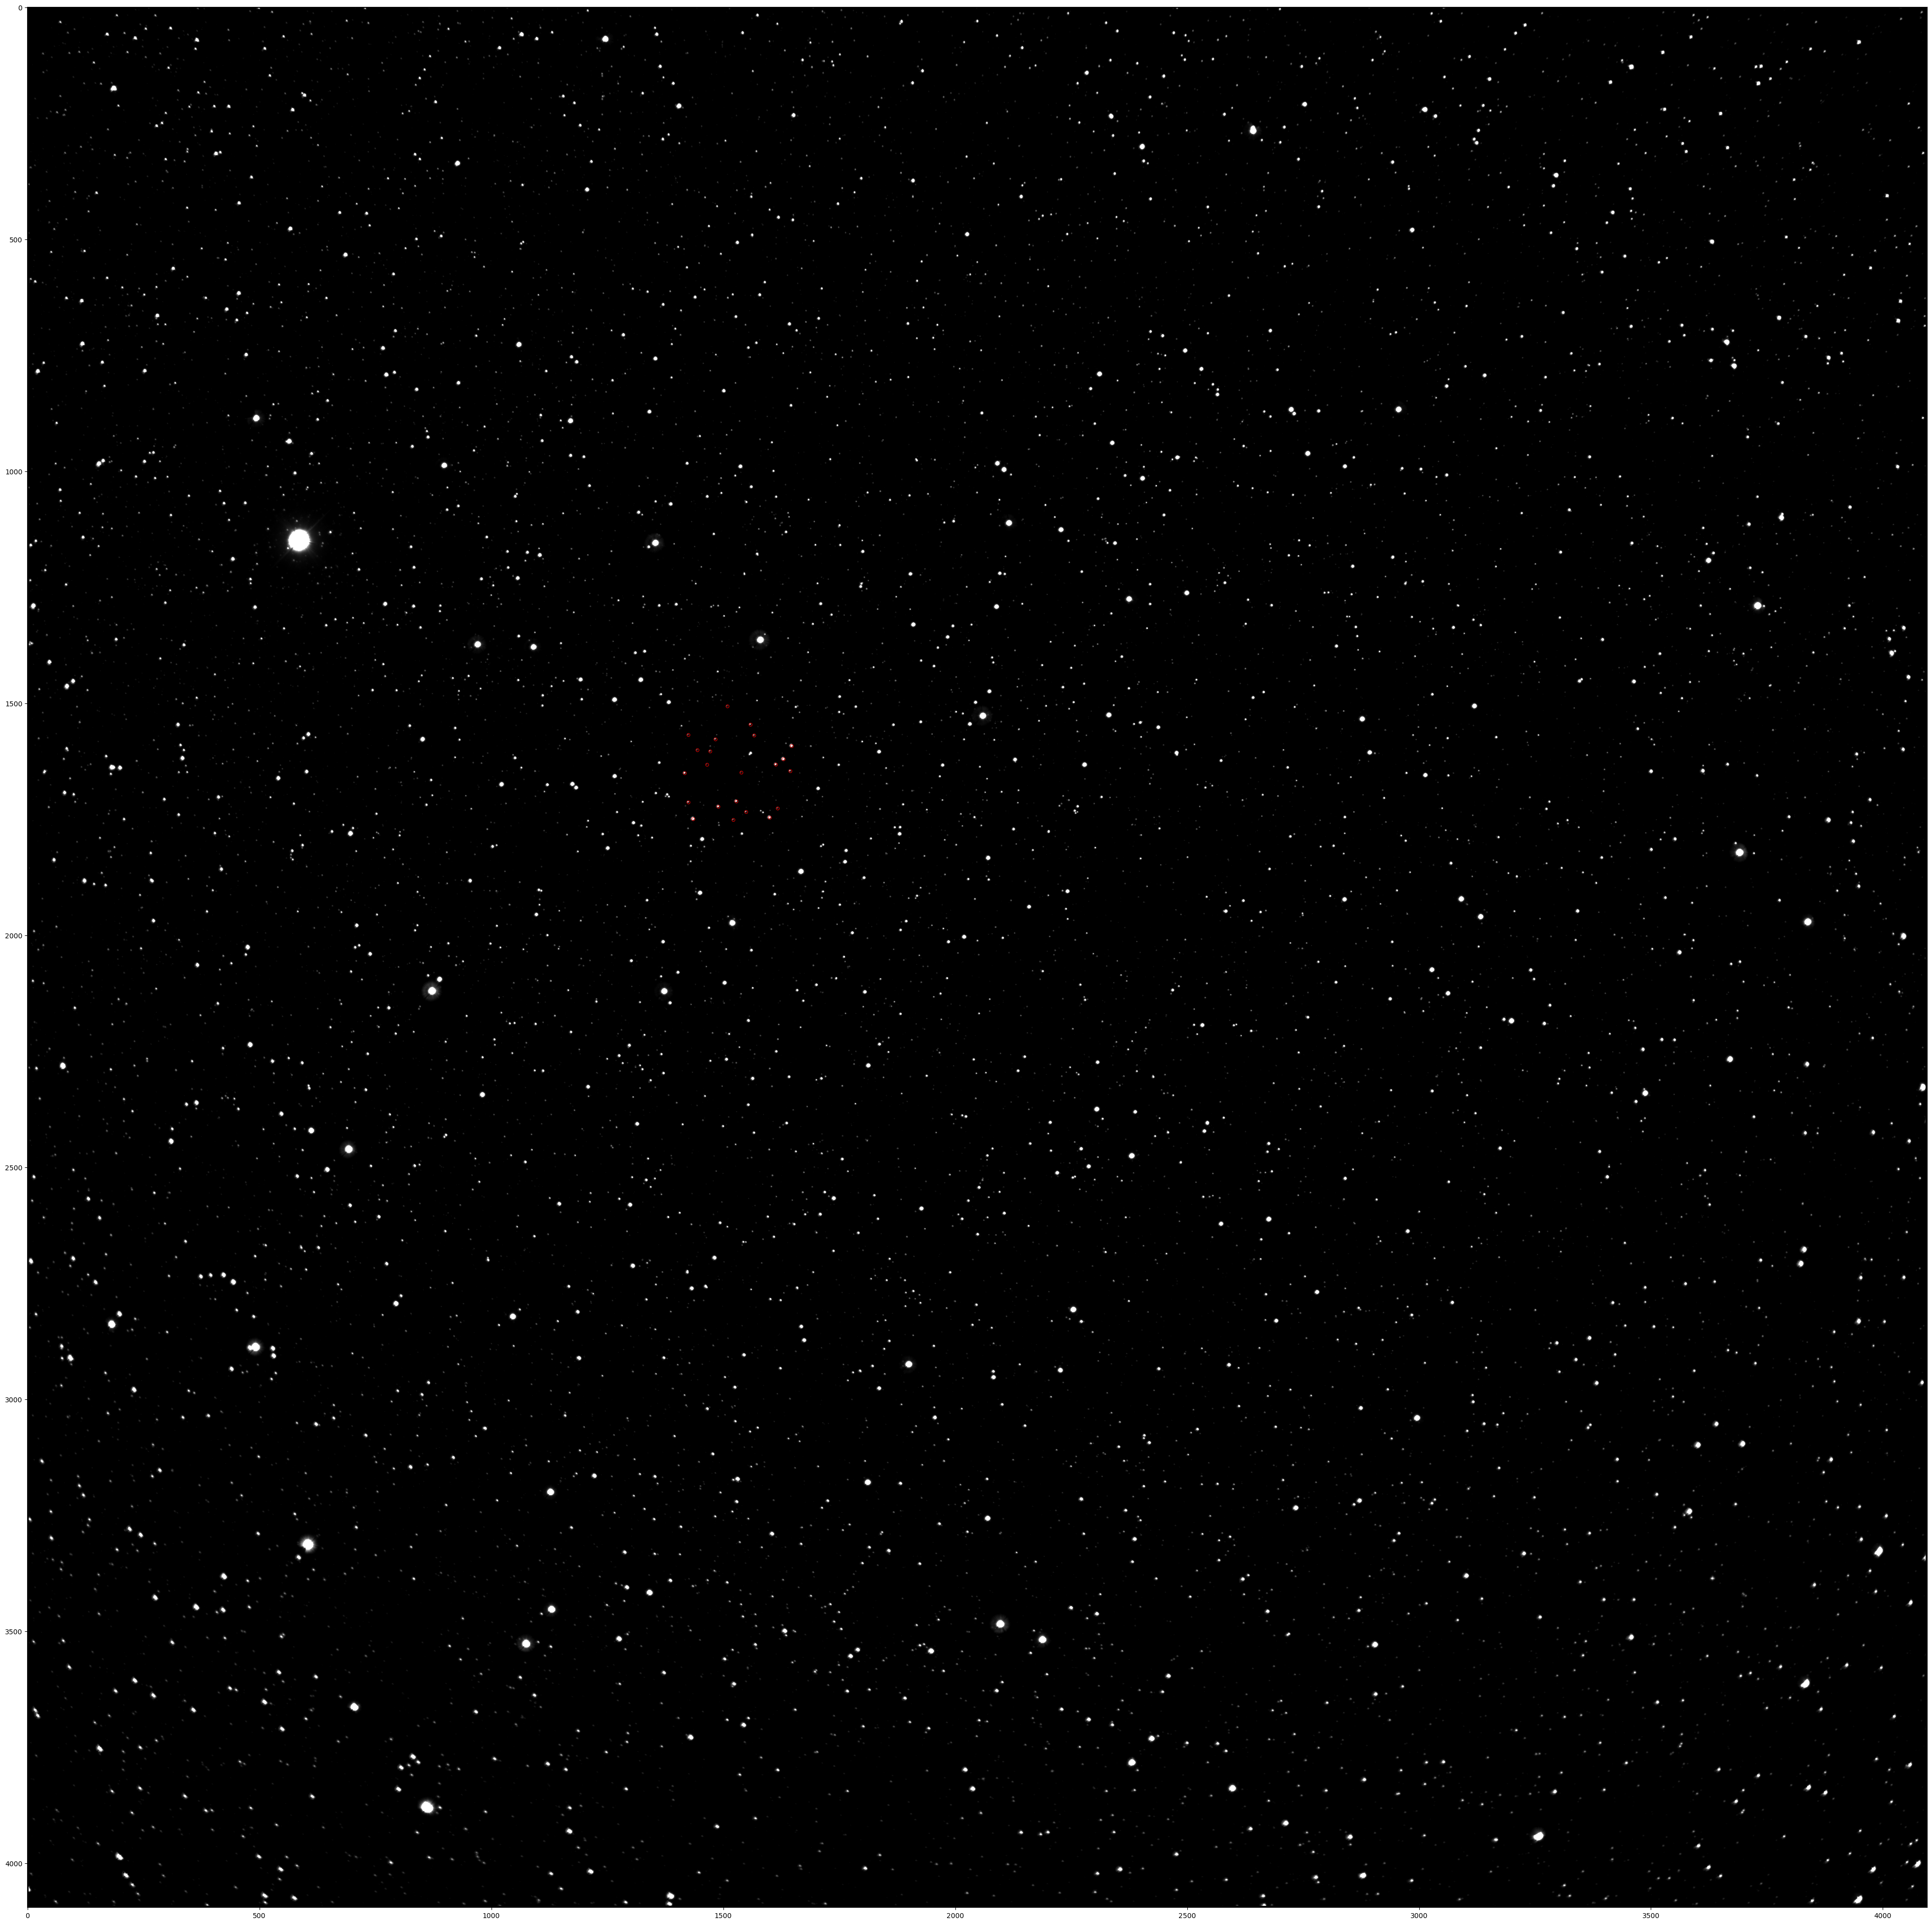

In [21]:
data, header = fits.getdata(rawFit, header = True)

figData = plt.gcf()
figData.set_size_inches(50, 50)


plt.imshow(data, cmap = 'gray', vmin = 5000, vmax = 30000)
plt.scatter(starParams['x'], starParams['y'], s = 20, facecolors='none', edgecolors='r', alpha = 0.7)
figData.savefig('markedStars.png', dpi=100)

In [22]:
#Closest neighbours calculation.

name = 'K01-1241'
positions = list(zip(starParams['x'], starParams['y']))

tree = KDTree(positions, 2)
knn = tree.get_knn([starParams['x'].loc[name], starParams['y'].loc[name]], 26, False)


starParamsSearch = starParams.reset_index()
starParamsSearch = starParamsSearch.astype(str)


for coords in knn:
    x = str(coords[0])
    y = str(coords[1])

    comparisonName = starParamsSearch['Name'].loc[(starParamsSearch['x'] == x) & (starParamsSearch['y'] == y)].iloc[0]
    print(comparisonName)

K01-1241
K01-1340
K01-1209
K01-1206
K01-1169
K01-1106
K01-1390
K01-1365
K01-1125
K01-1191
K01-1422
K01-1064
K01-1229
K01-1162
K01-1374
K01-1410
K01-1240
K01-1144
K01-1350
K01-1100
K01-1417
K01-1004


0.9848191620000009
1.0520100140000004
1.0778070280000005
1.0209486680000008
1.0693386170000005
1.0400627470000003
0.9753249789999998
1.0375887339999998
1.009738595
1.0807754029999987
0.508314114
1.005638231999999
1.037284058000001
1.042202649
0.9510756549999986
1.040347714000001
1.563012436000001
1.0395355310000003
1.0087788059999996
1.0408414830000012
0.9416574299999994
1.0608951170000003


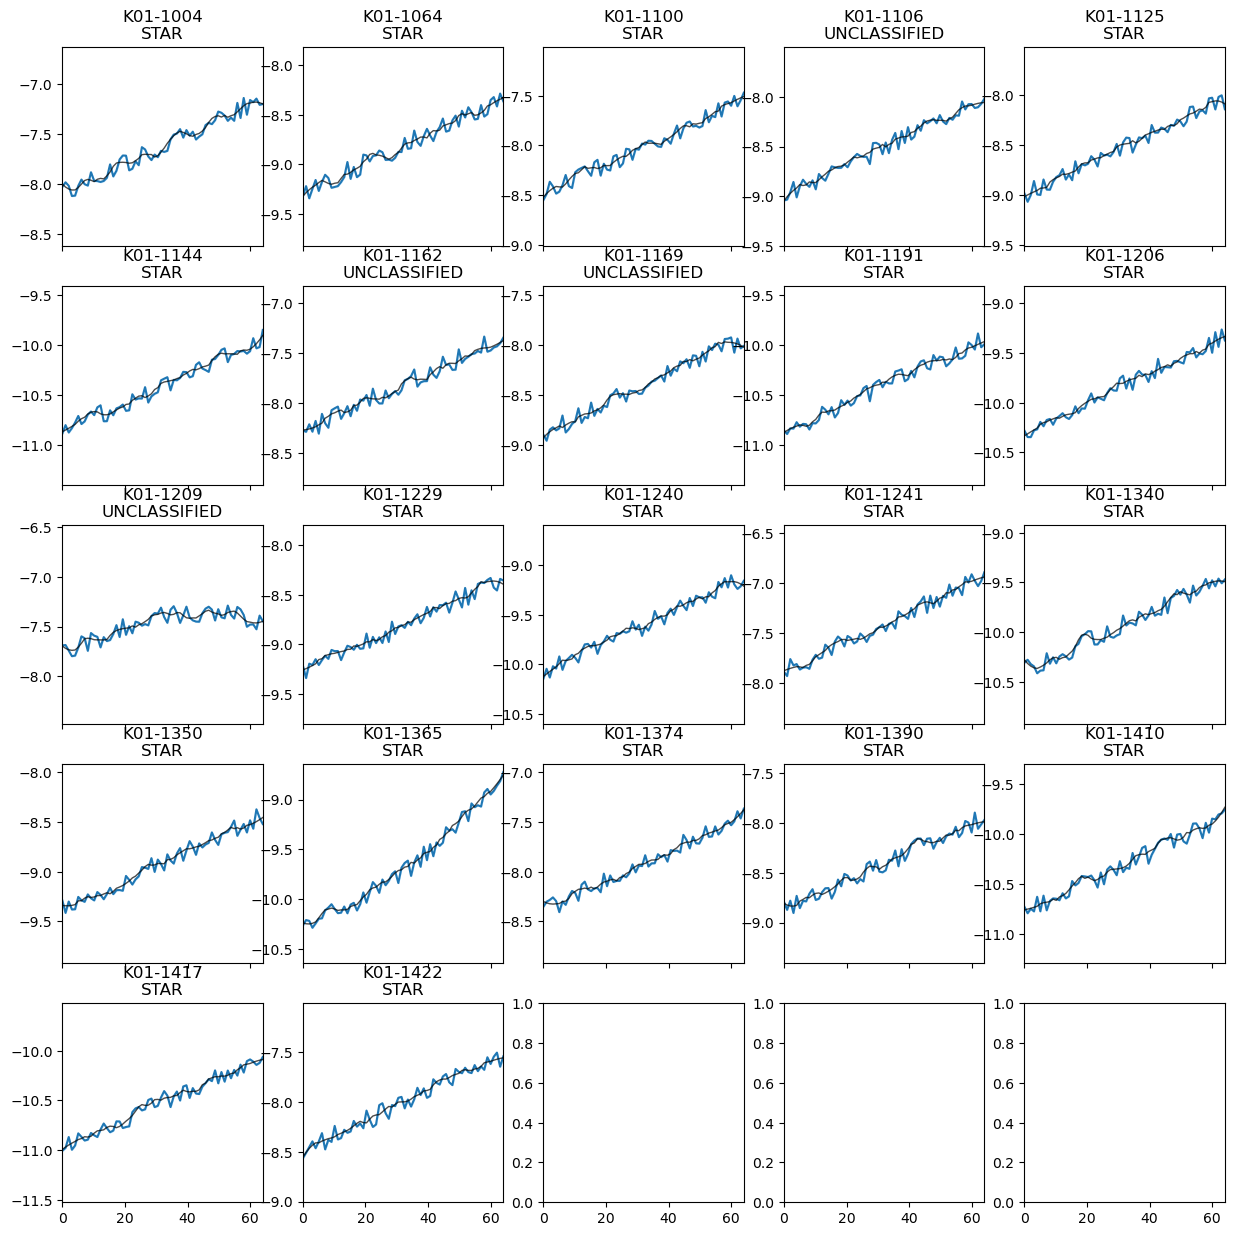

In [23]:
#Plot differential photometry of all stars.

rows = 5
start = 1000

offset = 0
fig, axs = plt.subplots(rows, 5, sharex = True, sharey = False, figsize = (15, 3*rows))

x = np.linspace(0, len(differentialMagnitudes), len(differentialMagnitudes))
count = 0

errorData = pd.read_csv(f'{target}_DifferentialErrors.csv')

for star in starName[:]:#start:start+5*rows]:
    j = count % 5
    i = count //5

    try:
        axs[i, j].plot(x, starMagnitudes[f'{star}'])
        axs[i, j].fill_between(x, 
                   starMagnitudes[f'{star}'] - errorData[f'{star} Error'],
                   starMagnitudes[f'{star}'] + errorData[f'{star} Error'],
                   alpha=0.2, color='#26a8ff')
        smoothed = savgol_filter(starMagnitudes[f'{star}'].to_numpy(), 10, 2)
        axs[i, j].plot(x, smoothed, 'black', alpha=0.7, linewidth=1)
        axs[i, j].set_title(f'{star}\n{starParams["Type"].loc[star]}')
        axs[i, j].set_ylim(starMagnitudes[f'{star}'].mean()-1, starMagnitudes[f'{star}'].mean()+1)
        axs[i, j].set_xlim(0, numImages)
        print(starMagnitudes[f'{star}'].max()- starMagnitudes[f'{star}'].min())

    except:
        continue
    count += 1

plt.show()